In [83]:
# Import required libaries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import wget 
import os 
import pandas as pd
import numpy as np 

HARD_DATA = True

# Data Extraction

In [84]:
from dotenv import load_dotenv
load_dotenv() # Reads the .env file in the current directory
import os

if HARD_DATA:
    ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
    ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
    storage_options = {
        "account_name": ACCOUNT_NAME,
        "account_key": ACCOUNT_KEY,
    }
    gold_prefix = "abfs://gold@ucalgarydatalake01.dfs.core.windows.net/calgary_cloud_quality_classification_2000_2025.parquet"

    imagery_df = pd.read_parquet(
        gold_prefix,
        storage_options=storage_options,
        engine="fastparquet",
    )

    imagery_df['month'] = imagery_df['date'].dt.month.astype(int)
    imagery_df['date'] = imagery_df['date'].astype(str)
    


# Data Cleaning

In [85]:
# Only select images that do not have clouds and are in summer months, this will be more complicated if we don't manually label the cloudy data 
if HARD_DATA:
    print(f'Total length of precleaned dataset: {len(imagery_df)}') 
    cleaned_df = imagery_df.query("cloud_fraction < 0.1 & cloud_fraction > 0 & month == 7")
    print(f'Total length of cleaned dataset: {len(cleaned_df)}')
    cleaned_df['month'] = cleaned_df['month'].astype(int)
    manual_df = pd.DataFrame()
    manual_df['year'] = range(2001,2025)
    manual_df['Area Estimate'] = [585,591,621,623,659,682,675,702,712,744,752,742,744,771,779,768,802,786,797,804,836,830,864,854]
    print(cleaned_df.dtypes)

Total length of precleaned dataset: 2173
Total length of cleaned dataset: 79
year                int64
date               object
rel_path           object
file_name          object
cloud_fraction    float64
quality_class       int64
month               int64
dtype: object


C:\Users\ctcas\AppData\Local\Temp\ipykernel_18888\2284019572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['month'] = cleaned_df['month'].astype(int)


In [86]:
# Alternative dataset, testing known good images 
if HARD_DATA == False:
    imagery_df = pd.read_csv('basic_good_image_set.csv')
    imagery_df = imagery_df.fillna('None')
    imagery_df['date'] = imagery_df['date'].astype(str)
    print(f'Total length of precleaned dataset: {len(imagery_df)}') 
    cleaned_df = imagery_df.query("Month == 7 & Cloudiness.eq('None') & Greenness.eq('High')")
    print(f'Total length of cleaned dataset: {len(cleaned_df)}')
    
    for im_fn in cleaned_df['date']:
        image = cv2.imread('./city_images/raw/basic_good_image_set/'+im_fn+'.jpg')
        cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+im_fn+'.jpg',image)

In [87]:
cleaned_df.dtypes

year                int64
date               object
rel_path           object
file_name          object
cloud_fraction    float64
quality_class       int64
month               int64
dtype: object

In [88]:
from PIL import Image

def decode_fft_polar_uint8(encoded: dict) -> np.ndarray:
    """
    Invert the encode_fft_polar_uint8() representation back to a complex FFT array.
    """
    mag_q = encoded["mag_q"].astype(np.float32)
    phase_q = encoded["phase_q"].astype(np.float32)
    mag_max = float(encoded["mag_max"])
    shape = tuple(encoded["shape"].tolist())

    # Dequantize magnitude
    mag_norm = mag_q / 255.0
    mag_log = mag_norm * mag_max
    mag = np.expm1(mag_log)

    # Dequantize phase
    phase_norm = phase_q / 255.0
    phase = phase_norm * (2 * np.pi) - np.pi

    real = mag * np.cos(phase)
    imag = mag * np.sin(phase)
    fft_arr = (real + 1j * imag).astype(np.complex64)

    return fft_arr.reshape(shape)

def fft_rgb_to_image(fft_block: np.ndarray, width: int, height: int) -> Image.Image:
    fft_block = np.asarray(fft_block)
    if fft_block.ndim != 3 or fft_block.shape[2] != 3:
        raise ValueError(f"Expected fft_block of shape (K, K, 3), got {fft_block.shape}")

    K_h, K_w, C = fft_block.shape
    if K_h != K_w:
        raise ValueError(f"Expected square block, got {fft_block.shape}")
    if C != 3:
        raise ValueError("Expected 3 channels (RGB)")

    H, W = int(height), int(width)

    full_fft = np.zeros((H, W, 3), dtype=fft_block.dtype)

    cy, cx = H // 2, W // 2
    half = K_h // 2

    y0, y1 = cy - half, cy - half + K_h
    x0, x1 = cx - half, cx - half + K_h

    full_fft[y0:y1, x0:x1, :] = fft_block

    F_unshift = np.fft.ifftshift(full_fft, axes=(0, 1))
    img_complex = np.fft.ifft2(F_unshift, axes=(0, 1))  # (H, W, 3)
    img_real = np.real(img_complex)

    img_real = np.clip(img_real, 0, 255).astype(np.uint8)
    return Image.fromarray(img_real)

In [89]:
import fsspec
import json
bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
if HARD_DATA:
    for i in range(len(cleaned_df)):
        year = cleaned_df.iloc[i]['year']
        date = cleaned_df.iloc[i]['date']
        #path = bronze_prefix + f"/year={year}/worldview_fft_{date.strip()}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
        path = bronze_prefix + f"/year={year}/worldview_fft_{date}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
        fs_,_,paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

        with fs_.open(paths[0], "rb") as f:
            data = np.load(f, allow_pickle=True)
            fft_arr = data["fft"]
            meta = json.loads(data["meta"].item())

        recon_img = fft_rgb_to_image(fft_arr,275,275) #how to get the image from an fft.
        numpy_image = np.array(recon_img)
        opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+date+'.jpg',opencv_image)


# Image Processing

In [90]:
# Improved image processing with boundaries to exclude surrounding towns
# Also tracks urban growth over time - city only grows, never shrinks

# HSV thresholds for green vegetation
lower_green = np.array([40, 40, 0]) 
upper_green = np.array([85, 255, 255]) 

lower_grey = 0  
upper_grey = 255

# Define outer boundary to exclude Airdrie, Okotoks, etc
outer_boundary = [
    [0.14, 0.30],  [0.25, 0.28],  [0.40, 0.23],  [0.60, 0.22],  [0.75, 0.23],
    [0.77, 0.38],  [0.92, 0.40],  [0.92, 0.60],  [0.88, 0.80],  [0.70, 0.87],
    [0.50, 0.90],  [0.30, 0.85],  [0.25, 0.70],  [0.10, 0.60],  [0.06, 0.40]
]

# Inner boundary is the city center from 2001 (always urban)
inner_boundary = [
    [0.14, 0.39],  [0.25, 0.39],  [0.40, 0.37],  [0.50, 0.37],  [0.58, 0.45],
    [0.65, 0.39],  [0.65, 0.41],  [0.65, 0.60],  [0.60, 0.80],  [0.55, 0.83],
    [0.50, 0.82],  [0.41, 0.79],  [0.31, 0.62],  [0.24, 0.60],  [0.14, 0.40]
]

print(f"Processing {len(cleaned_df)} images...")

# Need to sort by year first
df_sorted = cleaned_df.sort_values('year')

# This stores what was urban in previous years
prev_urban = None
images_processed = []

for idx, row in df_sorted.iterrows():
    im_fn = row['date']
    year = row['year']
    
    # Load the image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + im_fn+'.jpg')
    h, w = img.shape[:2]
    
    # Make outer boundary mask
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    outer = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    
    # Make inner boundary mask
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Area between inner and outer boundaries
    between = cv2.subtract(outer, inner)
    
    red_channel = img[:, :, 2]
    blue_channel = img[:, :, 0]
    # ret, red_bitmask = cv2.threshold(red_channel, 65, 150, cv2.THRESH_BINARY) 
    ret, red_bitmask = cv2.threshold(red_channel, 75, 150, cv2.THRESH_BINARY) 
    #ret, blue_bitmask = cv2.threshold(blue_channel, 55, 150, cv2.THRESH_BINARY) 
    #rb_mask = cv2.bitwise_and(red_bitmask,blue_bitmask) 

    ret, not_green = cv2.threshold(red_bitmask, 0, 255, cv2.THRESH_BINARY)

    # Find green areas and invert
    # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # green = cv2.inRange(hsv, lower_green, upper_green)
    # not_green = cv2.bitwise_not(green)
    # not_green = cv2.bitwise_or(stage_1,not_green)
    # In between region, only keep non-green parts

    between_urban = cv2.bitwise_and(between, not_green)
    
    # Combine inner + between urban areas
    this_year = cv2.bitwise_or(inner, between_urban)
    
    # Add previous years urban areas (cumulative growth)
    # if prev_urban is not None:
    #     result = cv2.bitwise_or(prev_urban, this_year)
    # else:
    #     result = this_year

    result = this_year
    
    prev_urban = result.copy()
    
    # Save result
    cv2.imwrite('./city_images/processed/basic_good_image_set/' + im_fn.split('.')[0] + '.bmp', result)
    images_processed.append(result)
    
    pixels = cv2.countNonZero(result)
    print(f"{year}: {pixels:,} pixels")

print(f"\nDone! Processed {len(images_processed)} images") 

Processing 79 images...
2002: 15,630 pixels
2002: 21,544 pixels
2002: 17,027 pixels
2002: 19,819 pixels
2002: 15,916 pixels
2003: 16,462 pixels
2003: 14,425 pixels
2003: 14,211 pixels
2003: 18,802 pixels
2003: 15,754 pixels
2003: 15,889 pixels
2003: 20,795 pixels
2004: 16,258 pixels
2004: 16,728 pixels
2006: 17,545 pixels
2006: 16,631 pixels
2007: 15,732 pixels
2007: 18,059 pixels
2007: 16,868 pixels
2007: 18,237 pixels
2007: 23,813 pixels
2007: 16,359 pixels
2008: 15,526 pixels
2008: 18,700 pixels
2009: 20,659 pixels
2010: 14,548 pixels
2010: 18,312 pixels
2011: 19,218 pixels
2011: 16,525 pixels
2011: 18,296 pixels
2012: 18,794 pixels
2012: 19,710 pixels
2013: 20,341 pixels
2013: 17,404 pixels
2013: 15,401 pixels
2014: 19,231 pixels
2014: 19,241 pixels
2014: 16,286 pixels
2014: 19,796 pixels
2014: 19,231 pixels
2014: 20,446 pixels
2015: 22,744 pixels
2015: 18,832 pixels
2015: 17,750 pixels
2017: 21,510 pixels
2017: 17,794 pixels
2017: 22,626 pixels
2017: 19,953 pixels
2017: 20,359 pix

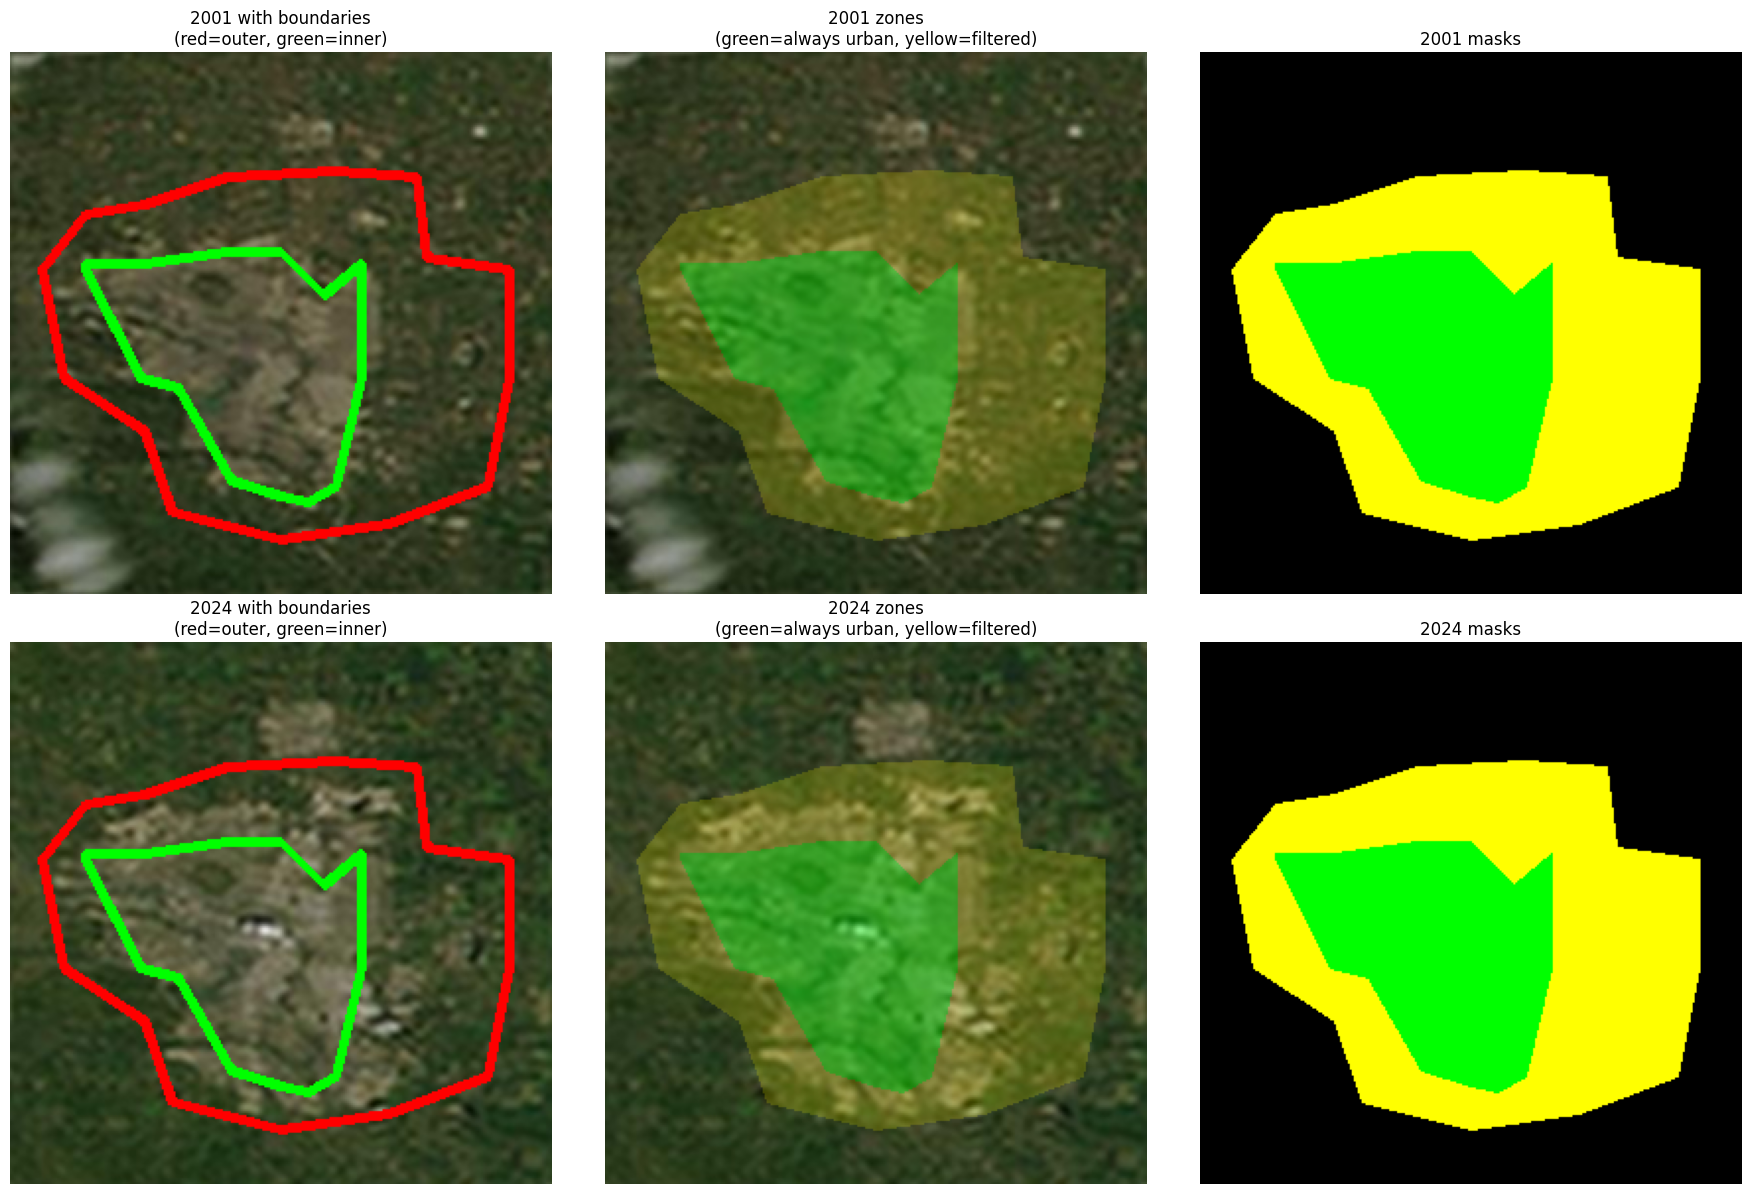

In [91]:
# Optional: Check boundaries on 2001 and 2024 images

# Get 2001 and 2024 images
year_2001 = cleaned_df[cleaned_df['year'] == 2002].iloc[0]
year_2024 = cleaned_df[cleaned_df['year'] == 2024].iloc[0]

test_years = [(2001, year_2001), (2024, year_2024)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (year, row) in enumerate(test_years):
    # Load image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + row['date']+'.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Make boundaries
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    
    outer = np.zeros((h, w), dtype=np.uint8)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Image with boundary lines
    img_lines = img_rgb.copy()
    cv2.polylines(img_lines, [outer_pts], True, (255, 0, 0), 3)
    cv2.polylines(img_lines, [inner_pts], True, (0, 255, 0), 3)
    axes[idx][0].imshow(img_lines)
    axes[idx][0].set_title(f'{year} with boundaries\n(red=outer, green=inner)')
    axes[idx][0].axis('off')
    
    # Colored overlay
    overlay = img_rgb.copy()
    overlay[inner == 255] = overlay[inner == 255] * 0.6 + np.array([0, 255, 0]) * 0.4
    between = cv2.subtract(outer, inner)
    overlay[between == 255] = overlay[between == 255] * 0.8 + np.array([255, 255, 0]) * 0.2
    axes[idx][1].imshow(overlay)
    axes[idx][1].set_title(f'{year} zones\n(green=always urban, yellow=filtered)')
    axes[idx][1].axis('off')
    
    # Just masks
    masks = np.zeros((h, w, 3), dtype=np.uint8)
    masks[inner == 255] = [0, 255, 0]
    masks[between == 255] = [255, 255, 0]
    axes[idx][2].imshow(masks)
    axes[idx][2].set_title(f'{year} masks')
    axes[idx][2].axis('off')

plt.tight_layout()
plt.show()

# Image Analysis

In [92]:
# Determine distances of image manually 
distance_width = 42 # km - determined from calculator: https://www.nhc.noaa.gov/gccalc.shtml
distance_height = 67 # km - determined from calculator: " 

area_per_year = pd.DataFrame()

for i in range(len(cleaned_df)):
    # im_fm = cleaned_df.iloc[i]['date']
    # print()
    image = cv2.imread('./city_images/processed/basic_good_image_set/'+cleaned_df.iloc[i]['date']+'.bmp',cv2.IMREAD_GRAYSCALE)

    # Calculate sq km per pixel 
    pixel_width = 275 
    pixel_height = 275
    sqkmpp = (distance_width*distance_height)/(pixel_height*pixel_width)
    
    # Calculate area estimate 
    area_estimate = cv2.countNonZero(image)*sqkmpp
    # print(area_estimate)
    # area_per_year.append(area_estimate)
    area_per_year.at[i,'year'] = cleaned_df.iloc[i]['year']
    area_per_year.at[i,'area_estimate'] = area_estimate

average_by_year = area_per_year.groupby(area_per_year['year'])['area_estimate'].mean()
print(average_by_year)


year
2002.0     669.302225
2003.0     618.418195
2004.0     613.703167
2006.0     635.843068
2007.0     676.401878
2008.0     636.773316
2009.0     768.719683
2010.0     611.358942
2011.0     670.262241
2012.0     716.365329
2013.0     659.186089
2014.0     708.421012
2015.0     735.838519
2017.0     760.883274
2018.0     763.897277
2019.0     626.801058
2020.0     680.374036
2021.0    1142.390975
2022.0     670.978532
2023.0     889.428655
2024.0     927.540912
Name: area_estimate, dtype: float64


In [93]:
years_manual = list(manual_df['year'])
manual_area = list(manual_df['Area Estimate'])
years_auto = average_by_year.index.tolist()
years_auto = [int(x) for x in years_auto]
per_error = [] 
for i in range(len(average_by_year)):
    error = (average_by_year.iat[i] - manual_area[i])/manual_area[i]*100
    per_error.append(error)


# Graph Visualization

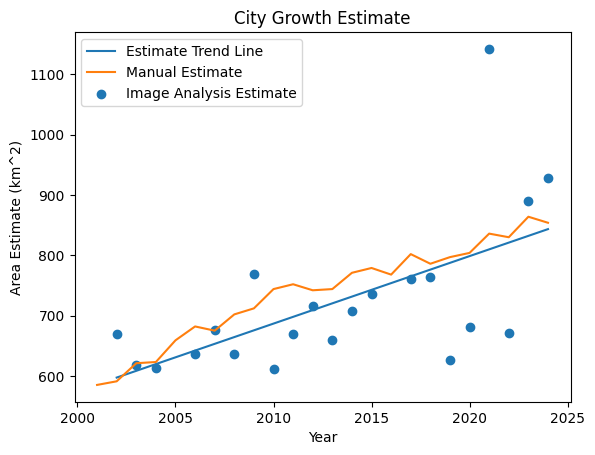

In [94]:
m, b = np.polyfit(years_auto, average_by_year.tolist(), 1)

# Create the regression line equation
y_pred = m * np.array(years_auto) + b
plt.plot(years_auto,y_pred,label='Estimate Trend Line')
plt.plot(years_manual,manual_area,label='Manual Estimate')
plt.scatter(average_by_year.index.tolist(),average_by_year.tolist(),label='Image Analysis Estimate')
plt.xlabel('Year')
plt.ylabel('Area Estimate (km^2)')
plt.title('City Growth Estimate')
plt.legend()

Average Error: 0.17529736431311155


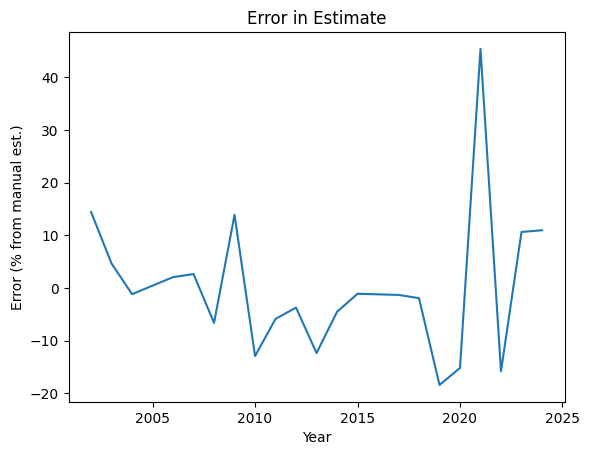

In [95]:
plt.plot(years_auto,per_error)
plt.xlabel('Year')
plt.ylabel('Error (% from manual est.)')
plt.title('Error in Estimate')
print(f"Average Error: {sum(per_error)/len(per_error)}")